# Azure Computer Vision 4 (Florence)

## Image Analysis V4.0 Captioning and Dense Captioning (public preview)

![Image](florence.jpg)

"Caption" replaces "Describe" in V4.0 as the significantly improved image captioning feature rich with details and sematic understanding. 

- Dense Captions provides more detail by generating one sentence descriptions of up to 10 regions of the image in addition to describing the whole image. 
- Dense Captions also returns bounding box coordinates of the described image regions. 
- There's also a new gender-neutral parameter to allow customers to choose whether to enable probabilistic gender inference for alt-text and Seeing AI applications. 
- Automatically deliver rich captions, accessible alt-text, SEO optimization, and intelligent photo curation to support digital content.

https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-describe-images-40?tabs=image

Azure Computer Vision updates: https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/whats-new#march-2023
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 3rd of May, 2023

In [3]:
import cv2
import json
import glob
import numpy as np
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Image as viewimage
from matplotlib import pyplot as plt
from PIL import Image
from pprintjson import pprintjson

In [4]:
sys.version

'3.11.1 (main, Mar 24 2023, 00:55:06) [GCC 11.3.0]'

In [5]:
load_dotenv("azure.env")

key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [6]:
IMAGES_DIR = "images"

In [7]:
RESULT_DIR = "results"

os.makedirs(RESULT_DIR, exist_ok=True)

In [8]:
url = (
    endpoint
    + "/computervision/imageanalysis:analyze?api-version=2023-02-01-preview&features=denseCaptions&language=en"
)

headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": key}

In [9]:
image_url = (
    "https://github.com/retkowsky/images/blob/master/car%20on%20fire.jpg?raw=true"
)

r = requests.get(image_url)
img = Image.open(BytesIO(r.content))
img

img.save(os.path.join(IMAGES_DIR, "image1.jpg"))

In [10]:
r = requests.post(url, data=json.dumps({"url": image_url}), headers=headers)

results = r.json()
pprintjson(results)

{
    "denseCaptionsResult": {
        "values": [
            {
                "text": "a fire truck and a car on fire",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 0,
                    "y": 0,
                    "w": 1200,
                    "h": 602
                }
            },
            {
                "text": "a fire truck on the road",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 332,
                    "y": 322,
                    "w": 185,
                    "h": 114
                }
            },
            {
                "text": "a car on fire with smoke coming out of the back",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 670,
                    "y": 401,
                    "w": 187,
                    "h": 117
                }
            },
            {
                "text": "a green sign with white te

In [11]:
main_caption = results["denseCaptionsResult"]["values"][0]
main_caption

print(
    "The main caption of the image is:",
    main_caption["text"],
    "with a confidence =",
    main_caption["confidence"],
)

The main caption of the image is: a fire truck and a car on fire with a confidence = 1.0


In [12]:
print("\033[1;31;34mDense captions:\n")

for idx, value in enumerate(results["denseCaptionsResult"]["values"], start=1):
    print(idx, value["text"], "=", round(value["confidence"], 3))

Dense captions:

1 a fire truck and a car on fire = 1.0
2 a fire truck on the road = 1.0
3 a car on fire with smoke coming out of the back = 1.0
4 a green sign with white text = 1.0
5 a green sign with a white arrow = 1.0
6 a car parked on the side of a road = 1.0
7 a person wearing a firefighter uniform = 1.0
8 a fire truck on the road = 1.0
9 firemen on the road with a fire truck = 1.0
10 a pole with a light on it = 1.0


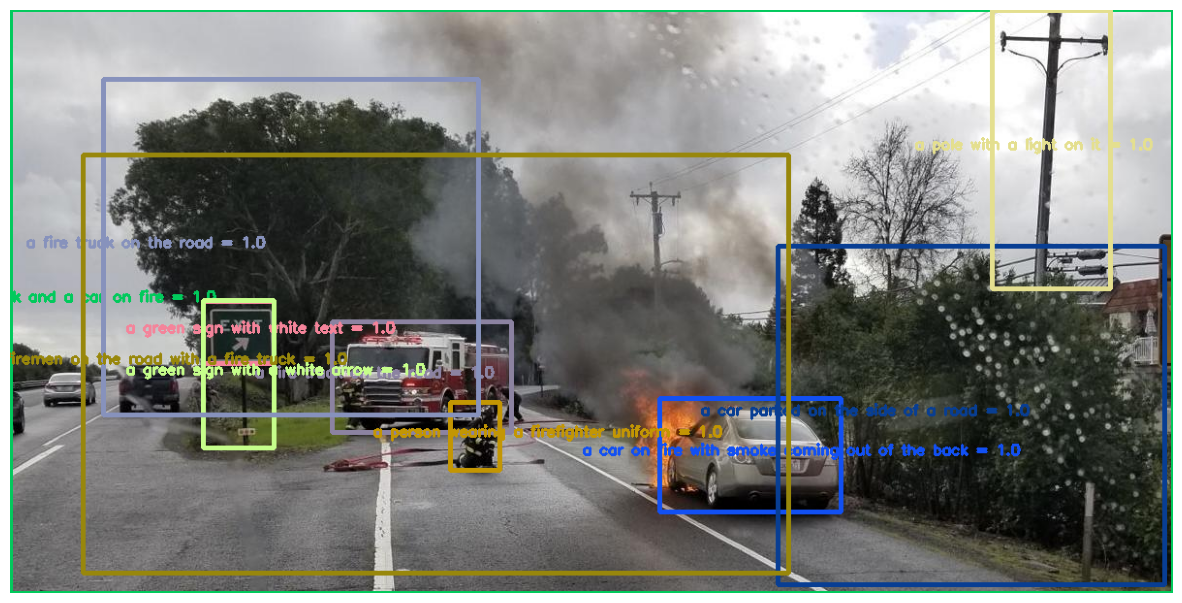

In [13]:
images = glob.glob("cropped_1_*.*")

for image in images:
    os.remove(image)

img = cv2.cvtColor(
    cv2.imread(os.path.join(IMAGES_DIR, "image1.jpg")), cv2.COLOR_BGR2RGB
)
imageCopy = img.copy()

for value in results["denseCaptionsResult"]["values"]:
    densecaption = value["text"]
    confidence = value["confidence"]
    x = value["boundingBox"]["x"]
    y = value["boundingBox"]["y"]
    w = value["boundingBox"]["w"]
    h = value["boundingBox"]["h"]

    caption = f"{densecaption} = {round(confidence, 2)}"
    color = list(np.random.random(size=3) * 256)
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(
        img,
        caption,
        (x - 80, int((y + y + h) / 2)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        2,
    )

    crop_img = imageCopy[y : y + h, x : x + w]
    cv2.imwrite(
        RESULT_DIR + "/cropped_1_" + densecaption + "_" + str(confidence) + ".jpg",
        cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB),
    )

plt.figure(figsize=(15, 12))
plt.axis("off")
plt.imshow(img)

plt.savefig(os.path.join(RESULT_DIR, "dense_captions_1.jpg"))

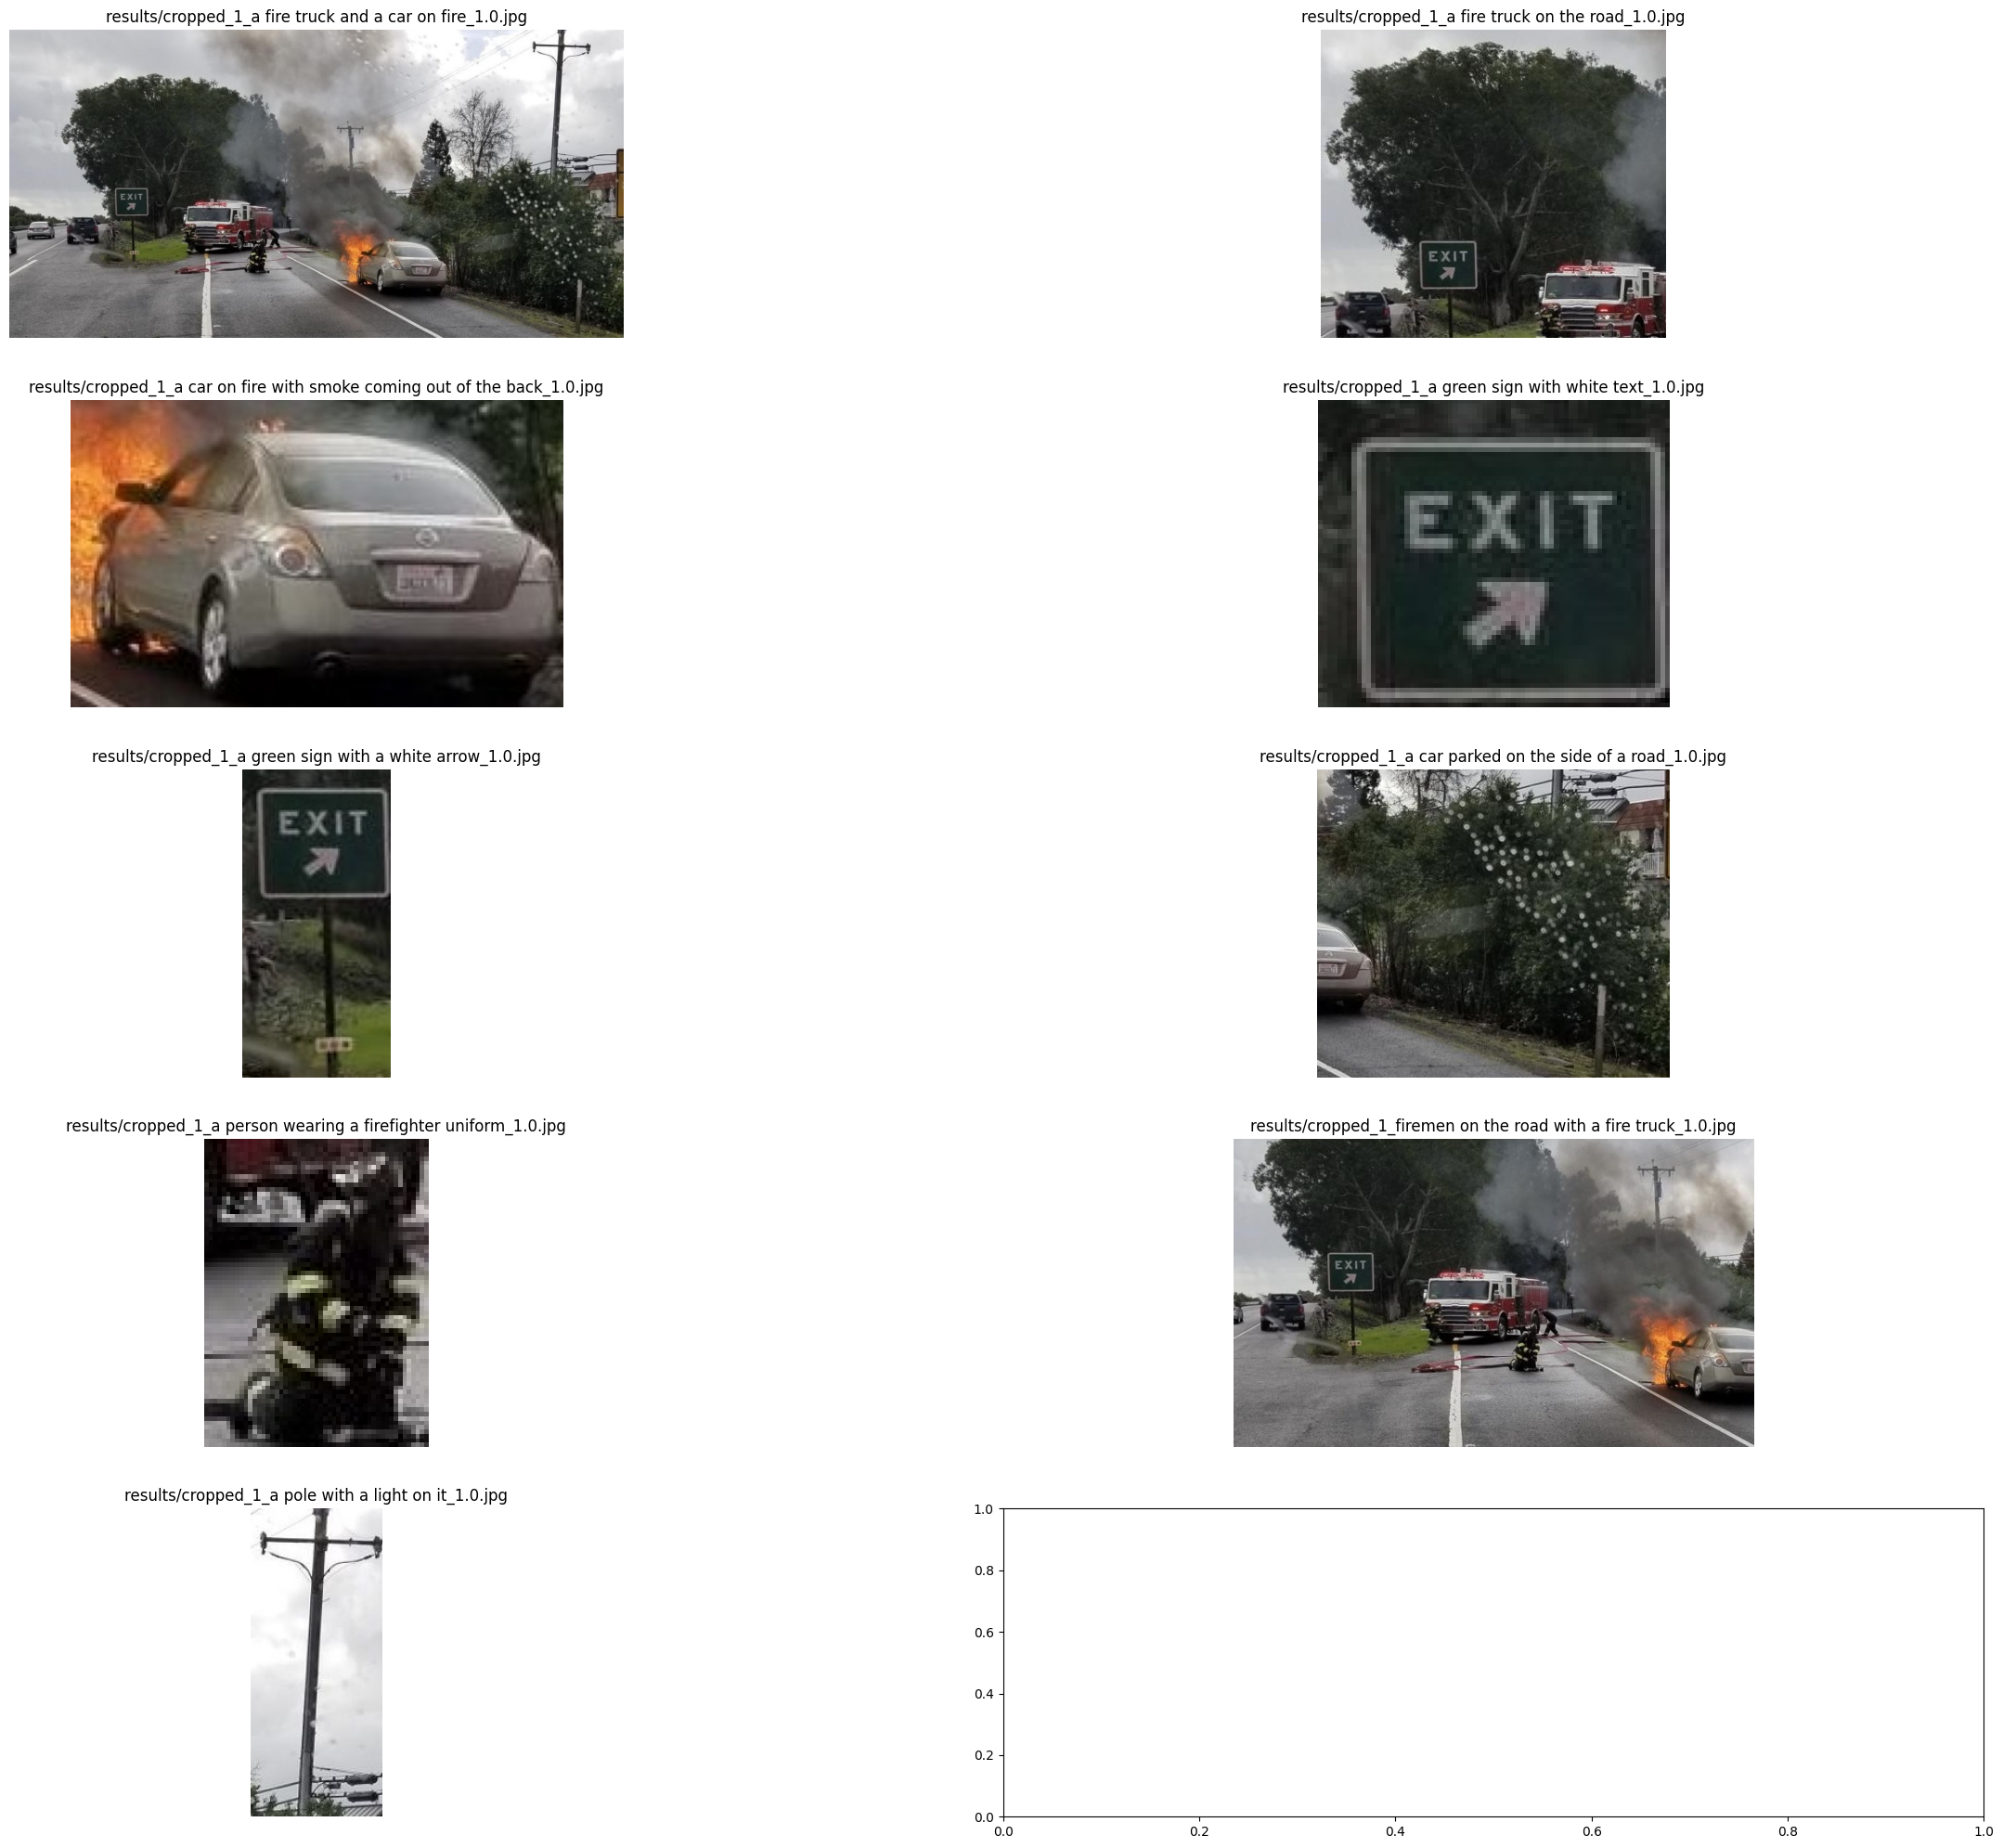

In [14]:
# List of image file names
image_files = glob.glob(RESULT_DIR + "/cropped_1_*.*")

# Load images
images = []
for file in image_files:
    img = Image.open(file)
    images.append(img)

# Create figure with subplots
num_images = len(images)
num_rows = (num_images // 2) + (num_images % 2 > 0)
fig, axes = plt.subplots(num_rows, 2, figsize=(30, 5 * num_rows))

# Display images on subplots
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(image_files[i])
        ax.axis('off')

plt.show()

## Using a local image file

In [15]:
IMAGES_DIR = "images"
image_extensions = (".jpg", ".jpeg", ".png", ".gif")

image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(image_extensions)]
image_files

['arc_triomphe.jpg',
 'businesscard.jpg',
 'car.jpg',
 'car.png',
 'car2.jpg',
 'cars.jpg',
 'cat.jpg',
 'drinks.jpg',
 'fashionprocess.png',
 'fruits.jpg',
 'image1.jpg',
 'office.jpg',
 'postalcard.jpg',
 'presentation.png',
 'sand.jpg',
 'street.jpg',
 'tomato.jpg',
 'whitecar.jpg']

In [16]:
local_file = os.path.join(IMAGES_DIR, "tomato.jpg")

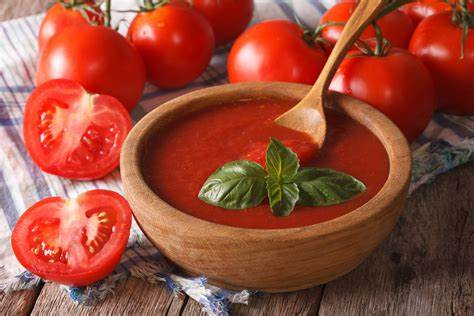

In [17]:
viewimage(filename=local_file)

In [18]:
with open(local_file, "rb") as f:
    data = f.read()

headers = {
    "Content-type": "application/octet-stream",
    "Ocp-Apim-Subscription-Key": key,
}

r = requests.post(url, data=data, headers=headers)

results = r.json()
pprintjson(results)

{
    "denseCaptionsResult": {
        "values": [
            {
                "text": "a bowl of tomato soup with a spoon",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 0,
                    "y": 0,
                    "w": 474,
                    "h": 316
                }
            },
            {
                "text": "a bowl of tomato soup with a spoon",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 111,
                    "y": 73,
                    "w": 297,
                    "h": 217
                }
            },
            {
                "text": "a bowl of tomato soup with a spoon",
                "confidence": 1.0,
                "boundingBox": {
                    "x": 0,
                    "y": 0,
                    "w": 467,
                    "h": 306
                }
            },
            {
                "text": "a close up of a tomato",
      

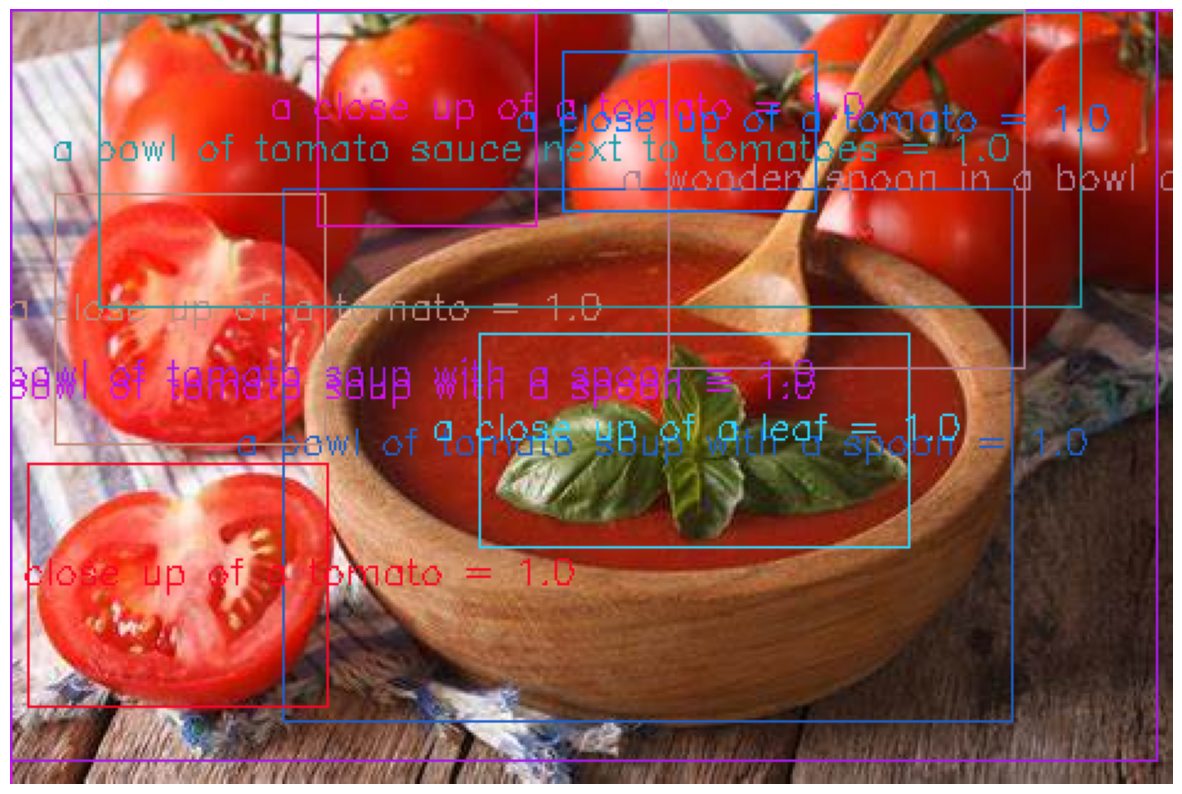

In [19]:
images = glob.glob(os.path.join(RESULT_DIR, "cropped_2_*.*"))

for image in images:
    os.remove(image)

img = cv2.cvtColor(cv2.imread(local_file), cv2.COLOR_BGR2RGB)
imageCopy = img.copy()

for value in results["denseCaptionsResult"]["values"]:
    densecaption = value["text"]
    confidence = value["confidence"]
    x = value["boundingBox"]["x"]
    y = value["boundingBox"]["y"]
    w = value["boundingBox"]["w"]
    h = value["boundingBox"]["h"]

    caption = f"{densecaption} = {round(confidence, 2)}"
    color = list(np.random.random(size=3) * 256)
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    cv2.putText(
        img,
        caption,
        (x - 20, int((y + y + h) / 2)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        1,
    )

    crop_img = imageCopy[y : y + h, x : x + w]
    cv2.imwrite(
        RESULT_DIR + "/cropped_2_" + densecaption + "_" + str(confidence) + ".jpg",
        cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB),
    )

plt.figure(figsize=(15, 12))
plt.axis("off")
plt.imshow(img)

plt.savefig(os.path.join(RESULT_DIR, "dense_captions_2.jpg"))

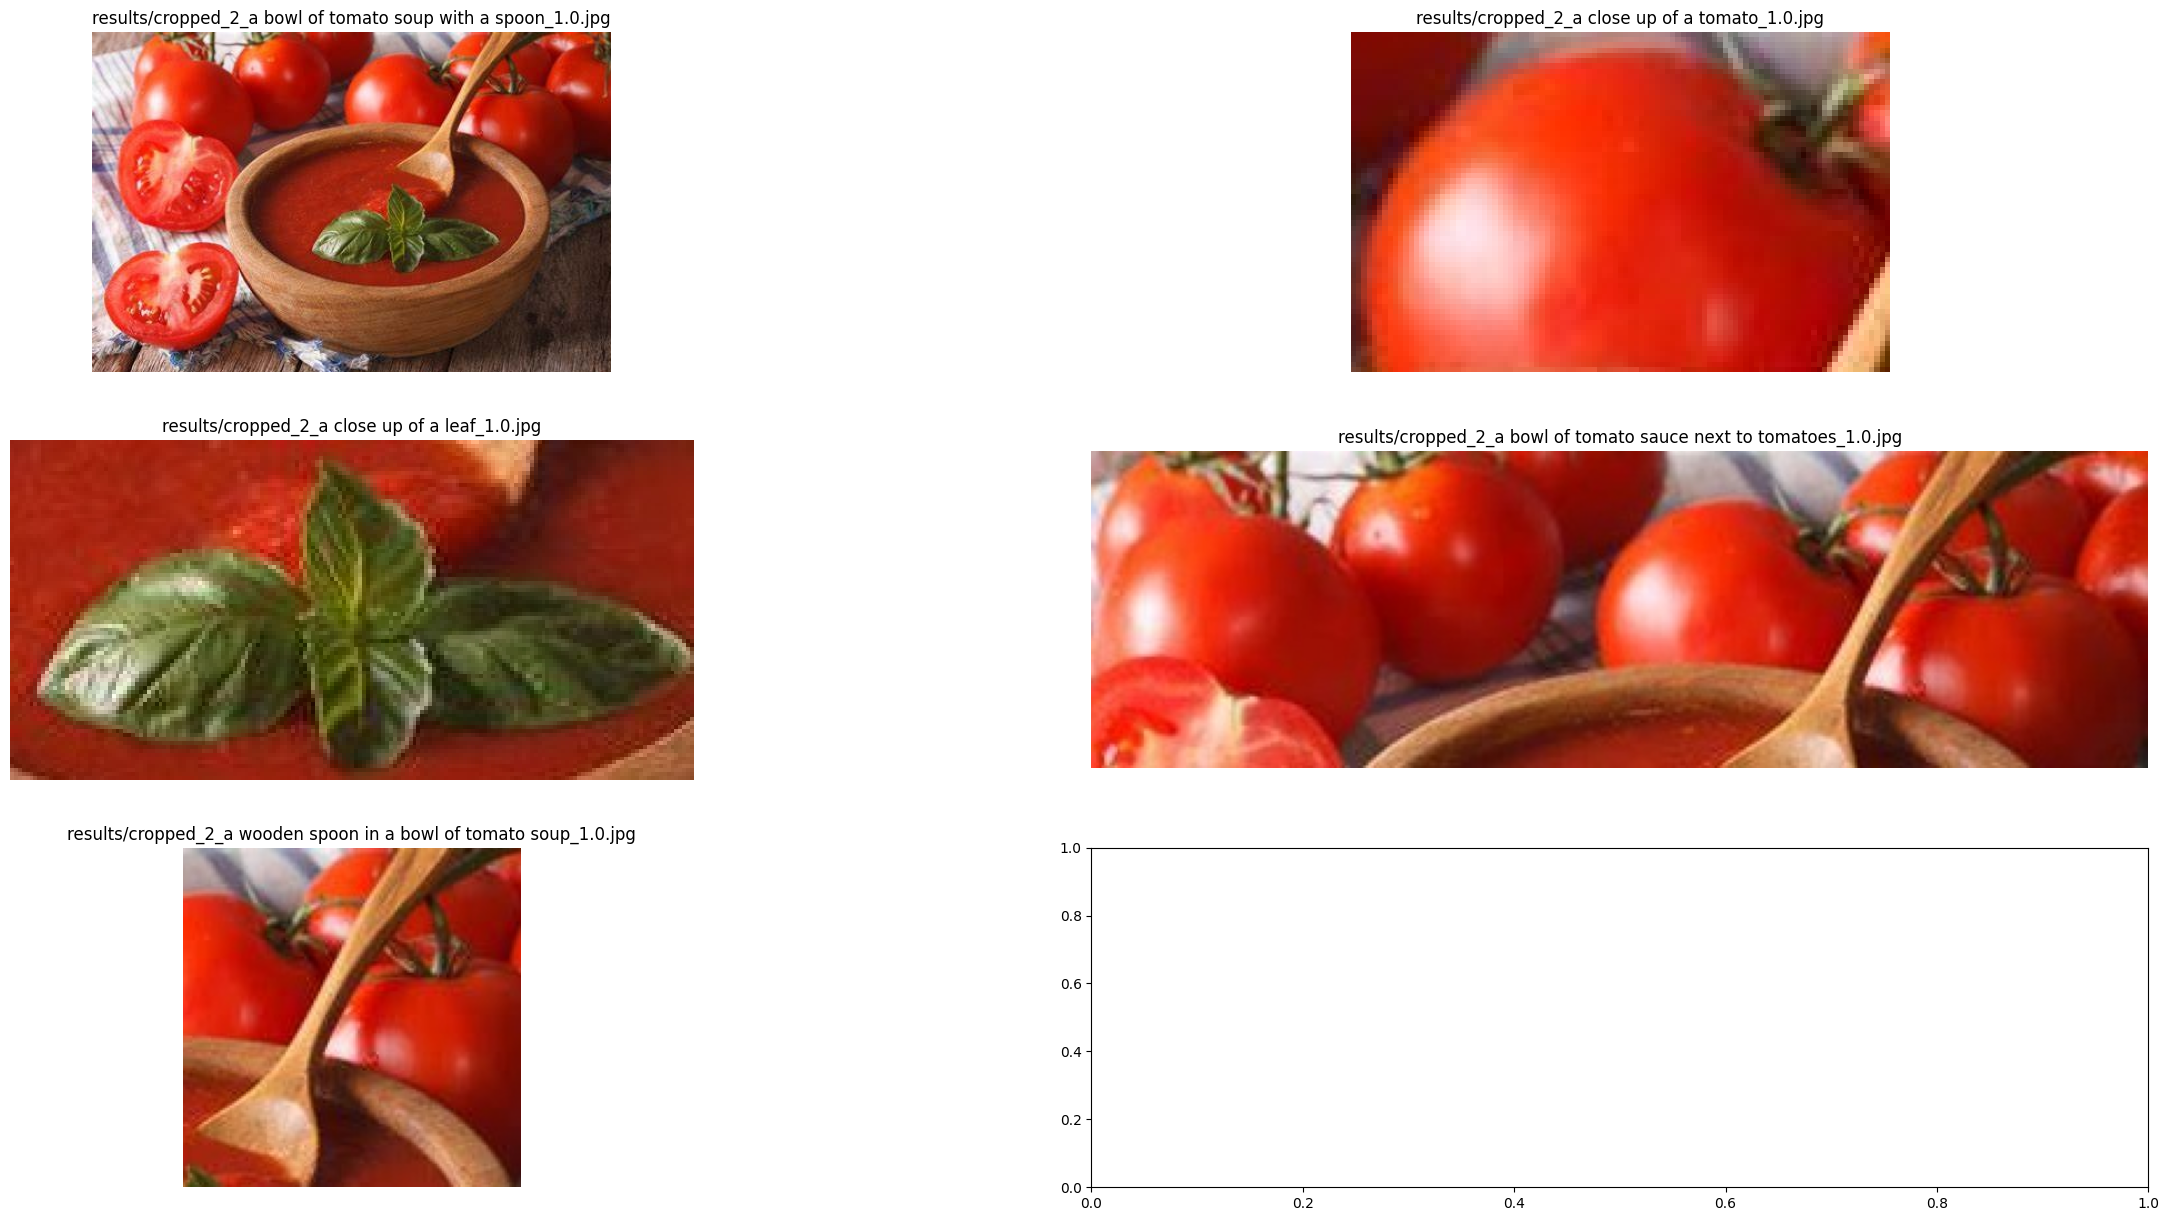

In [20]:
# List of image file names
image_files = glob.glob(RESULT_DIR + "/cropped_2_*.*")

# Load images
images = []
for file in image_files:
    img = Image.open(file)
    images.append(img)

# Create figure with subplots
num_images = len(images)
num_rows = (num_images // 2) + (num_images % 2 > 0)
fig, axes = plt.subplots(num_rows, 2, figsize=(30, 5 * num_rows))

# Display images on subplots
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(image_files[i])
        ax.axis('off')

plt.show()